# Linear Least Square Fitting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib notebook 

# Declaring variables

Simulation data from synchroton.

In [2]:
synch_data = pd.read_csv('Synch_spectrum.txt',sep = "\s+", names = ['Frequency (Hz)','Intensity (erg cm-2 s-1 sr-1 Hz-1)'],skiprows = [0,1])
# xpoints = synch_data['Frequency (Hz)']
# ypoints = synch_data['Intensity (erg cm-2 s-1 sr-1 Hz-1)']

Averages of the intensities for the 9 different areas in the sky.

In [3]:
avg_data = pd.read_csv('avg_intensities.txt',sep = "\s+", names = ['Frequency (GHz)','Intensity'],skiprows = [0,1])

xpoints = avg_data['Frequency (GHz)'].iloc[:30] 
ypoints_dict = {}
for y in np.arange(9):
    ypoints_dict['ypoints'+str(y)] = avg_data['Intensity'].iloc[y*30:30*(y+1)]


In [4]:
#points for cubic fit
# xpoints = np.array([-3,-2,-1,0,1,1.5,2,2.5, 3]) 
# ypoints = np.array([-24,-5,2,-5,4,7,15,20,30])

xmatrix= [] #linear
xmatrix_quad = [] #quadratic
xmatrix_cub = [] #cubic
xmatrix_pow = [] #power function
yval_log = [] #y vector for power
sigma_sq = []

ypoints = ypoints_dict['ypoints0']
total = np.sum(xpoints)
avg_x = total / xpoints.size
one_arr = np.ones([xpoints.size,1]) #array of ones which is concatenated to matrices
arr = xpoints[np.arange(xpoints.size)].values.reshape((xpoints.size,1)) #array of x values

# Determining x matrices and y vector

Here, I am taking the x and y points and adding them to their respective matrices. Note that the 'xmatrix' is equivalent to the A matrix in Adrian's notes. For a linear or quadratic x matrix:

$$X_{linear} = \begin{bmatrix}
1 & x_{1} \\
1 & x_{2} \\
\vdots & \vdots \\
\end{bmatrix}, \quad
X_{quadratic} = \begin{bmatrix}
1 & x_{1} & x_{1}^{2}\\
1 & x_{2} & x_{2}^{2} \\
\vdots & \vdots & \vdots\\
\end{bmatrix}
$$

For a cubic function just add another column for $x^3$. While the y vector is just the y points:
$\bar{y} = \begin{bmatrix}
y_{1} \\
y_{2} \\
\vdots \\
\end{bmatrix}
$

In [5]:
xmatrix = np.hstack([one_arr, arr]) #appending array of ones to array of xvalues
xmatrix_quad = np.hstack([xmatrix,arr**2]) #appending xmatrix to array of xvalues squared 
xmatrix_cub = np.hstack([xmatrix_quad,arr**3]) #appending xmatrix_quad to array of xvalues cubed

# Power Law

This is an attempt to fit a power law in the form of $y = \beta x^\alpha$. To fit the power law, it must be linearized since, according to Adrian's notes, the "linear part of the term 'linear fit' just means linear in the parameters". One way to do that (based on online searching) is by applying log to both sides to make:

$log(y) = log (\beta x^\alpha) = log(\beta) + log(x^\alpha) = log(\beta) + \alpha log(x)$

Therefore, the linearization of $y = \beta x^\alpha$ is $log(y) = log(\beta) + \alpha log(x)$. Let $y^{'}=log(y)$ and $x^{'}=log(x)$ so that $y^{'} = log(\beta) + \alpha x^{'}$.

With this, we can pretty much proceed as with the linear case but here the x matrix and y vector will be:

$$X_{power} = \begin{bmatrix}
1 & log(x_{1}) \\
1 & log(x_{2}) \\
\vdots & \vdots \\
\end{bmatrix}, \quad
\bar{y} = \begin{bmatrix}
log(y_{1}) \\
log(y_{2}) \\
\vdots \\
\end{bmatrix}
$$

In [6]:
xmatrix_pow = np.hstack([one_arr,np.log(arr)]) #appending array of ones to array of log xvalues
yval_log = np.log(ypoints.values.reshape((ypoints.size,1))) #array of log yvalues

# Noise covariance matrix

This method is based on Adrian's notes to determing the $\hat{x}$ for $y^{model} = A\hat{x}$. From his notes, $\hat{x}$ is defined as $\hat{x} = [A^TN^{-1}A]^{-1}A^TN^{-1}\bar{y}$.

From the earlier code, I already found $A$ = xmatrix and $\bar{y}$. To find $N$, I first need to find the variance or $\sigma^{2}$. The $N$ matrix is as follows:
$$ N = \begin{pmatrix}
\sigma_{1}^{2} & 0 & 0 &\ldots{} \\
0 & \sigma_{2}^{2} & 0 & \ldots{} \\
0 & 0 & \sigma_{3}^{2} & \ldots{} \\
\vdots & \vdots & \ddots \\
\end{pmatrix} $$
To find $\sigma^{2}$, I used the following formula:
$$\sigma^{2} = \frac{1}{N} \sum_{i}^{N}{(x_{i} - \mu)^{2}}$$
where $N$ is the number of terms and $\mu$ is the mean.

In [7]:
# calculating variance and reshaping
variance =(((ypoints - avg_x)**2)/(xpoints.size)).values.reshape((ypoints.size,1)) 
variance = np.hstack(variance)

rd = np.random.default_rng()
yerr= rd.random((ypoints.size))*10**10
variance = np.hstack(yerr**2) #stack array horizontally
noise_cov = np.diag(variance) 
# noise_cov = np.identity(xpoints.size)

Since I have determined the values ($A, N, \bar{y}$) to find $\hat{x}$, it's just a matter of multiplying everything for $\hat{x} = [A^TN^{-1}A]^{-1}A^TN^{-1}\bar{y}$. I broke down the steps of the process:
<ol>
<li>$A^TN^{-1}$</li>
<li>$A^TN^{-1}\bar{y}$</li>
<li>$[A^TN^{-1}A]^{-1}$</li>
<li>$\hat{x} = [A^TN^{-1}A]^{-1}A^TN^{-1}\bar{y}$</li>
<li>$y^{model} = A\hat{x}$</li>
</ol>	


In [8]:
#returns y_model and x_bar (parameters)
def y_model(m,yval):
    dot_matrix = np.dot(m.T,np.linalg.inv(noise_cov)) #Step 1
    doty_matrix = np.dot(dot_matrix,yval) #Step 2
    inv_matrix = np.linalg.inv(np.dot(dot_matrix,m)) #Step 3
    x_bar = np.dot(inv_matrix, doty_matrix) #Step 4
    y_model = np.dot(m, x_bar) #Step 5
    return y_model, x_bar

# Error Covariance

This is to find error information on final parameters to ascertain how far the fit is to the true parameters. To determine it, use the error covariance defined as $V= [A^{T}N^{-1}A]^{-1}$. The square root of the diagonal of $V$ gives the error bar of each parameter. The off-diagonal elements tell us how the errors on different parameters are correlated. Note this is based on Adrian's notes.

In [9]:
def error_cov(a_matrix):
    dot_matrix = np.dot(a_matrix.T,np.linalg.inv(noise_cov)) #Step 1 from Noise covariance matrix section
    error = np.linalg.inv(np.dot(dot_matrix,a_matrix)) #Step 3 from Noise covariance matrix section
    return error

def error_bar(a_matrix):
    return np.sqrt(np.diag(error_cov(a_matrix))) #taking the square root of the diagonal of V

# Calling Functions and Graphing

<IPython.core.display.Javascript object>


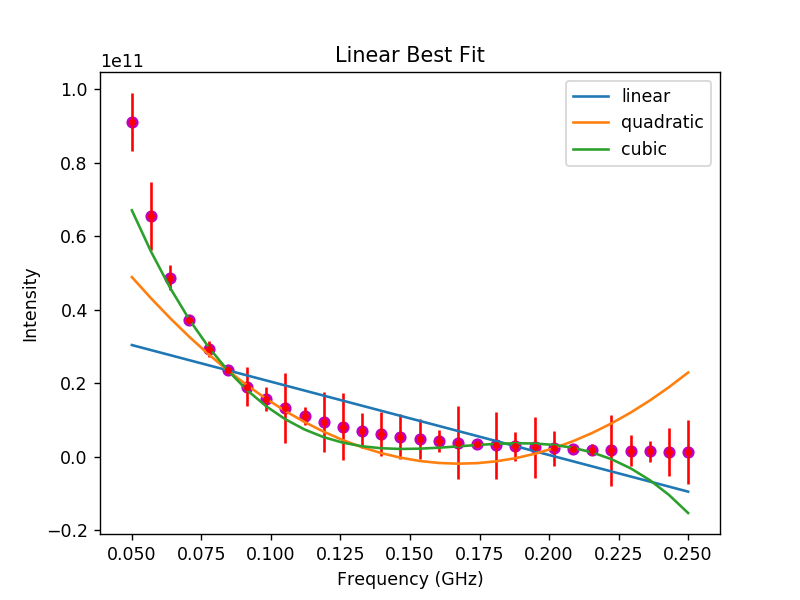

<IPython.core.display.Javascript object>


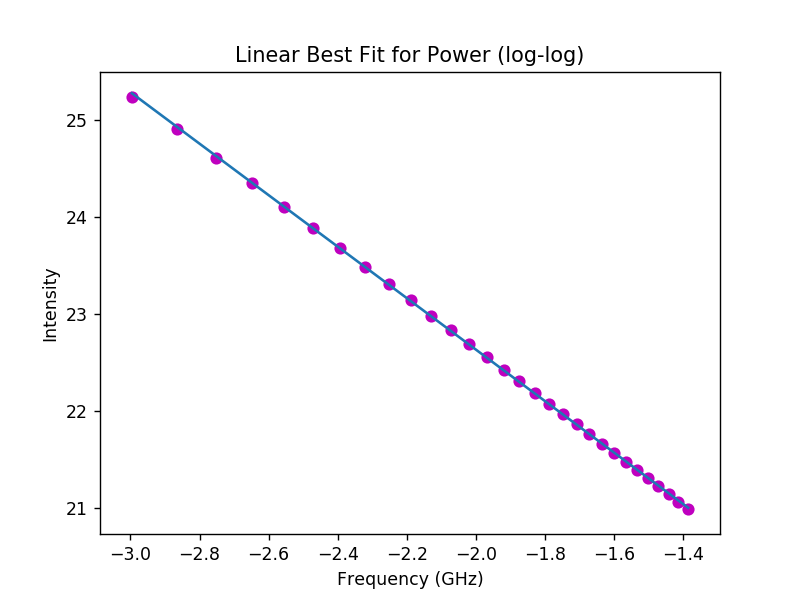

Text(0, 0.5, 'Intensity')

In [17]:
lin_fit, lin_param = y_model(xmatrix, ypoints)
quad_fit, quad_param = y_model(xmatrix_quad, ypoints)
cub_fit, cub_param = y_model(xmatrix_cub, ypoints)
pow_fit, pow_param = y_model(xmatrix_pow, yval_log)

#plot for first figure
plt.figure(1)
# rd = np.random.default_rng()
# yerr= rd.random((ypoints.size))*10**10
plt.errorbar(xpoints,ypoints,yerr,fmt='r.') 
plt.plot(xpoints, lin_fit, label='linear')
plt.plot(xpoints, quad_fit, label='quadratic')
plt.plot(xpoints, cub_fit, label='cubic')

# plt.scatter(avg_data['Frequency (GHz)'],avg_data['Intensity'], color='m')
plt.scatter(xpoints,ypoints, color='m')
# plt.scatter(xpoints,ypoints_dict['ypoints6'],color='y')

plt.legend(loc='upper right')
plt.title("Linear Best Fit")
plt.xlabel(xpoints.name)
plt.ylabel(ypoints.name)

#plot for second figure
plt.figure(2)
plt.plot(np.log(xpoints), pow_fit, label='power')
plt.scatter(np.log(xpoints),yval_log, color='m')
plt.title("Linear Best Fit for Power (log-log)")
plt.xlabel(xpoints.name)
plt.ylabel(ypoints.name)

# Errors for Parameters

This is the error for parameters of the linear fit. The parameters are $b$ for intercept and $m$ for slope from the equation $y=mx+b$.

In [11]:
print('Error covariance for linear fit is\n', error_cov(xmatrix))
print('\nThe slope (m) is', lin_param[1],'+/-', error_bar(xmatrix)[1], '(',lin_param[1]+error_bar(xmatrix)[1],',',
      lin_param[1]-error_bar(xmatrix)[1],')')
print('The intercept (b) is', lin_param[0],'+/-', error_bar(xmatrix)[0],'(',lin_param[0]+error_bar(xmatrix)[0],',',
      lin_param[0]-error_bar(xmatrix)[0],')')

Error covariance for linear fit is
 [[ 2.06278876e+16 -2.41401708e+17]
 [-2.41401708e+17  2.84430506e+18]]

The slope (m) is -199448528509.64844 +/- 1686506762.747168 ( -197762021746.90128 , -201135035272.3956 )
The intercept (b) is 40382788520.30615 +/- 143624119.14246944 ( 40526412639.44862 , 40239164401.16368 )


This is the error for the parameter of the power law fit. The parameters are $log(\beta)$ and $\alpha$ for the equation $y^{'} = log(\beta) + \alpha x^{'}$. Note that $y^{'}=log(y)$ and $x^{'}=log(x)$ and that it's for a log-log graph.

In [12]:
# print('Error covariance for power law fit is \n', error_cov(xmatrix_pow))
# print('\nLog(beta) is', pow_param[1],'+/-', error_bar(xmatrix_pow)[1], '(',pow_param[1]+error_bar(xmatrix_pow)[1],',',
#       pow_param[1]-error_bar(xmatrix_pow)[1],')')
# print('Alpha is', pow_param[0],'+/-', error_bar(xmatrix_pow)[0],'(',pow_param[0]+error_bar(xmatrix_pow)[0],',',
#       pow_param[0]-error_bar(xmatrix_pow)[0],')')

Calculating sigma using a different method and finding the corresponding error for the power law parameters. Here, it seems that the error has been substantially reduced. The error for log is $$\delta y^{'}= \frac{d log(y)}{dy} = \frac{\delta y}{y}$$.

In [13]:
# sigma = (1/(np.sqrt(np.abs(yval_log)))).reshape((ypoints.size,1))
# sigma= np.hstack(sigma)
# noise_cov = np.diag(sigma)
# err_pow = error_cov(xmatrix_pow)
# print(err_pow)
# print('\nLog(beta) is', pow_param[1],'+/-', error_bar(xmatrix_pow)[1], '(',pow_param[1]+error_bar(xmatrix_pow)[1],',',
#       pow_param[1]-error_bar(xmatrix_pow)[1],')')
# print('Alpha is', pow_param[0],'+/-', error_bar(xmatrix_pow)[0],'(',pow_param[0]+error_bar(xmatrix_pow)[0],',',
#       pow_param[0]-error_bar(xmatrix_pow)[0],')')

# Goodness of Fit

### $\chi^{2}=\sum_{i=1} \frac{(y_{i}-\hat{m}_{i}-\hat{b})^{2}}{\sigma_{i}^{2}}$

In [14]:
var = np.sum(((ypoints - avg_x)**2)/(xpoints.size))
residual_sq = (ypoints-lin_fit)**2
chi_square = np.sum(residual_sq/(var))
print(chi_square)

10.043739373445622


In [15]:
var = np.sum(((ypoints - avg_x)**2)/(xpoints.size))
residual_sq = (ypoints-lin_fit)**2
chi_square = np.sum(residual_sq/(var))